In [1]:
from sklearnex import patch_sklearn, config_context
patch_sklearn()

ModuleNotFoundError: No module named 'sklearnex'

In [2]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor,StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import missingno as msno
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

### 导入数据

In [3]:
train = pd.read_excel("./data/附件1语音业务用户满意度数据.xlsx")

### 数据预览

In [4]:
train.shape

(5433, 55)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5433 entries, 0 to 5432
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   用户id               5433 non-null   int64  
 1   语音通话整体满意度          5433 non-null   int64  
 2   网络覆盖与信号强度          5433 non-null   int64  
 3   语音通话清晰度            5433 non-null   int64  
 4   语音通话稳定性            5433 non-null   int64  
 5   是否遇到过网络问题          5433 non-null   int64  
 6   居民小区               5433 non-null   int64  
 7   办公室                5433 non-null   int64  
 8   高校                 5433 non-null   int64  
 9   商业街                5433 non-null   int64  
 10  地铁                 5433 non-null   int64  
 11  农村                 5433 non-null   int64  
 12  高铁                 5433 non-null   int64  
 13  其他，请注明             5433 non-null   int64  
 14  用户描述               275 non-null    object 
 15  手机没有信号             5433 non-null   int64  
 16  有信号无法拨通            5433 

### 缺失值处理

In [6]:
train_data = pd.DataFrame.copy(train, deep=True)

In [7]:
# 根据附件5填补缺失数据
train_data['是否关怀用户'] = train_data['是否关怀用户'].fillna(0)    
train_data['是否去过营业厅'] = train_data['是否去过营业厅'].fillna(0)

In [8]:
train_data.isnull().sum().sort_values(ascending=False)/len(train_data)*100

用户描述.1               97.993742
用户描述                 94.938340
重定向驻留时长              78.409718
重定向次数                78.409718
当月欠费金额                0.092030
客户星级标识                0.092030
是否实名登记用户              0.092030
是否5G网络客户              0.092030
终端品牌类型                0.092030
是否4G网络客户（本地剔除物联网）     0.092030
前第3个月欠费金额             0.092030
终端品牌                  0.073624
外省流量占比                0.036812
农村                    0.000000
当月ARPU                0.000000
套外流量（MB）              0.000000
办公室                   0.000000
套外流量费（元）              0.000000
外省语音占比                0.000000
语音通话-时长（分钟）           0.000000
省际漫游-时长（分钟）           0.000000
居民小区                  0.000000
当月MOU                 0.000000
高铁                    0.000000
前3月ARPU               0.000000
前3月MOU                0.000000
GPRS总流量（KB）           0.000000
GPRS-国内漫游-流量（KB）      0.000000
是否遇到过网络问题             0.000000
语音通话稳定性               0.000000
语音通话清晰度               0.000000
网络覆盖与信号强度             0.000000
ARPU（家庭宽

<AxesSubplot:>

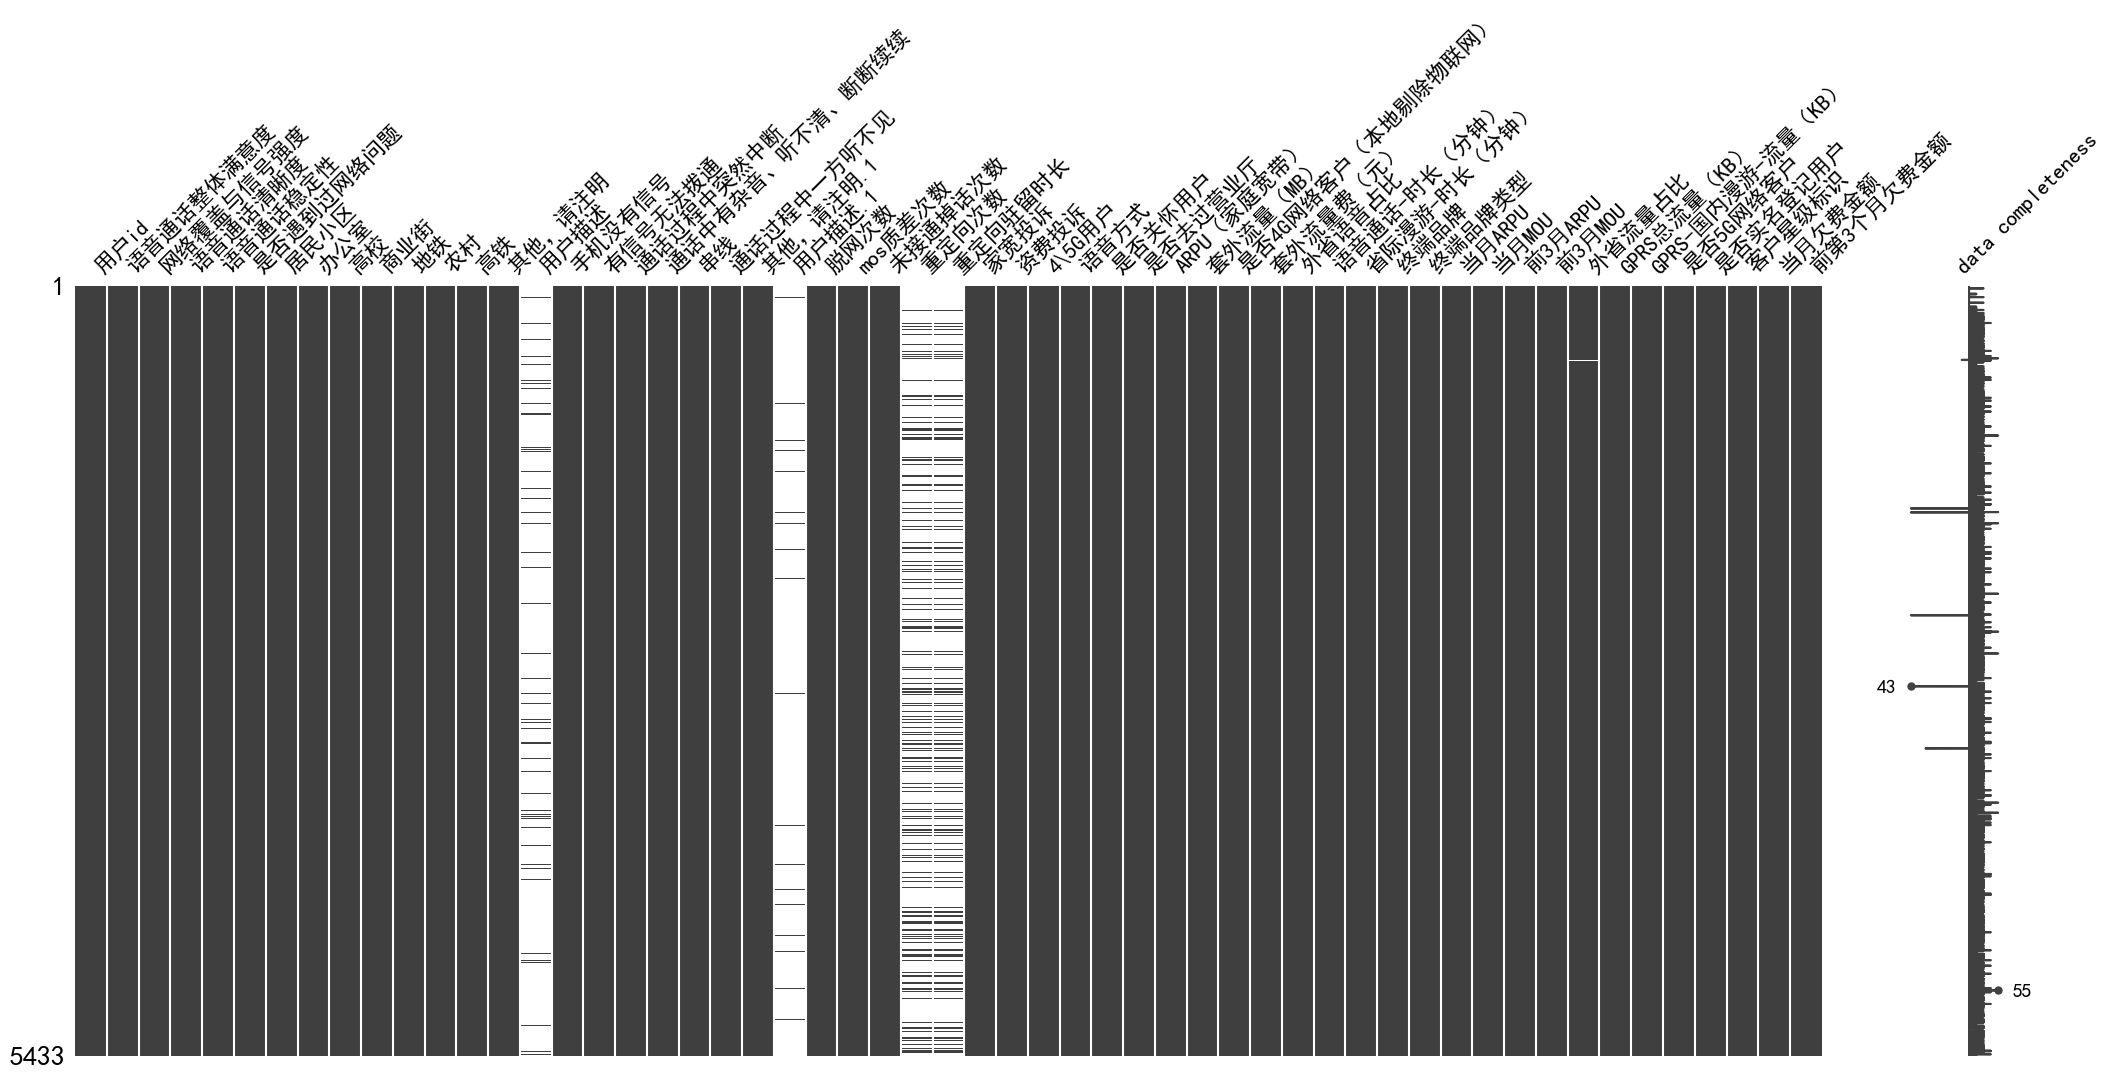

In [9]:
msno.matrix(train_data, labels=True)

In [10]:
train_data = train_data.drop(['用户描述', '用户描述.1', '重定向驻留时长', '重定向次数', '终端品牌', '终端品牌类型'], axis=1)

In [11]:
train_data.isnull().sum().sort_values(ascending=False)/len(train_data)*100

前第3个月欠费金额            0.092030
当月欠费金额               0.092030
客户星级标识               0.092030
是否实名登记用户             0.092030
是否5G网络客户             0.092030
是否4G网络客户（本地剔除物联网）    0.092030
外省流量占比               0.036812
外省语音占比               0.000000
语音方式                 0.000000
是否关怀用户               0.000000
是否去过营业厅              0.000000
ARPU（家庭宽带）           0.000000
套外流量（MB）             0.000000
套外流量费（元）             0.000000
当月ARPU               0.000000
语音通话-时长（分钟）          0.000000
省际漫游-时长（分钟）          0.000000
资费投诉                 0.000000
当月MOU                0.000000
前3月ARPU              0.000000
前3月MOU               0.000000
GPRS总流量（KB）          0.000000
GPRS-国内漫游-流量（KB）     0.000000
4\5G用户               0.000000
用户id                 0.000000
语音通话整体满意度            0.000000
未接通掉话次数              0.000000
网络覆盖与信号强度            0.000000
语音通话清晰度              0.000000
语音通话稳定性              0.000000
是否遇到过网络问题            0.000000
居民小区                 0.000000
办公室                  0.000000
高校        

In [12]:
# msno.matrix(train_data, labels=True)

#### 特征编码

In [109]:
train_data=train_data.replace({
        '是否投诉': {'是': 1, '否': 0},
        '是否关怀用户': {'是': 1, '否': 0},
        '4\\5G用户': {'2G': 0, '4G': 1, '5G': 2},
        '是否去过营业厅': {'是': 1, '否': 0},
        '是否4G网络客户（本地剔除物联网）': {'是': 1, '否': 0},
        '是否5G网络客户': {'是': 1, '否': 0},
        '是否实名登记用户':{'是': 1, '否': 0},
        '客户星级标识': {'未评级': 0, '准星': 1, '一星': 2, '二星': 3, '三星': 4, '白金卡': 5, '钻石卡': 6, '银卡': 7,'金卡': 8},
        '语音方式': {'CSFB': 0, 'EPSFB': 1, 'GSM': 2, 'VOLTE':3, 'VONR':4, 'VoLTE':5},

        '是否遇到过网络问题': {1: 0, 2: 1},

        '居民小区': {-1: 0},
        '办公室': {-1: 0, 2: 1},
        '高校': {-1: 0, 3: 1},
        '商业街': {-1: 0, 4: 1},
        '地铁': {-1: 0, 5: 1},
        '农村': {-1: 0, 6: 1},
        '高铁': {-1: 0, 7: 1},
        '其他，请注明': {-1: 0, 98: 1},

        '手机没有信号': {-1: 0},
        '有信号无法拨通': {-1: 0, 2: 1},
        '通话过程中突然中断': {-1: 0, 3: 1},
        '通话中有杂音、听不清、断断续续': {-1: 0, 4: 1},
        '串线': {-1: 0, 5: 1},
        '通话过程中一方听不见': {-1: 0, 6: 1},
        '其他，请注明.1': {-1: 0, 98: 1},

    })

In [14]:
train_data

,用户id,语音通话整体满意度,网络覆盖与信号强度,语音通话清晰度,语音通话稳定性,是否遇到过网络问题,居民小区,办公室,高校,商业街,...,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,是否实名登记用户,客户星级标识,当月欠费金额,前第3个月欠费金额
0,1,10,6,6,6,0,0,1,0,0,...,0.0,480,1.0,8450801,8450801,1.0,0.0,7.0,0.0,0.00
1,2,2,1,1,1,0,1,1,0,1,...,0.0,480,1.0,17425910,17425910,1.0,1.0,7.0,0.0,0.00
2,3,10,7,7,7,0,0,0,0,0,...,0.0,413,1.0,6215849,6215849,0.0,0.0,4.0,0.0,3.76
3,4,6,7,7,6,0,1,1,0,0,...,0.0,301,1.0,5370710,5370710,1.0,0.0,4.0,0.0,0.00
4,5,5,5,4,3,0,0,1,0,0,...,0.0,1193,1.0,3857521,3857521,0.0,0.0,7.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,5429,10,10,10,8,0,0,1,0,0,...,0.0,320,0.0,16654303,0,0.0,0.0,3.0,0.0,0.00
5429,5430,10,10,10,10,0,1,1,0,0,...,0.0,147,0.0,627901,0,1.0,0.0,4.0,0.0,0.00
5430,5431,6,5,7,4,0,0,0,0,1,...,0.0,150,0.0,6816663,0,0.0,0.0,7.0,0.0,0.00
5431,5432,9,9,10,9,0,0,0,0,0,...,0.0,82,0.0,1841891,0,0.0,0.0,4.0,0.0,0.00


In [15]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
用户id,5433.0,2.717000e+03,1.568516e+03,1.0,1359.0,2717.0,4075.0,5.433000e+03
语音通话整体满意度,5433.0,8.679919e+00,2.261380e+00,1.0,8.0,10.0,10.0,1.000000e+01
网络覆盖与信号强度,5433.0,8.339591e+00,2.419866e+00,1.0,8.0,9.0,10.0,1.000000e+01
语音通话清晰度,5433.0,8.632984e+00,2.204067e+00,1.0,8.0,10.0,10.0,1.000000e+01
语音通话稳定性,5433.0,8.428308e+00,2.374087e+00,1.0,8.0,10.0,10.0,1.000000e+01
是否遇到过网络问题,5433.0,4.735873e-01,4.993478e-01,0.0,0.0,0.0,1.0,1.000000e+00
居民小区,5433.0,3.392233e-01,4.734893e-01,0.0,0.0,0.0,1.0,1.000000e+00
办公室,5433.0,2.048592e-01,4.036358e-01,0.0,0.0,0.0,0.0,1.000000e+00
高校,5433.0,2.153506e-02,1.451729e-01,0.0,0.0,0.0,0.0,1.000000e+00
商业街,5433.0,8.098656e-02,2.728396e-01,0.0,0.0,0.0,0.0,1.000000e+00


In [16]:
# 缺失值填充
train_data['前第3个月欠费金额'].fillna((train_data['前第3个月欠费金额'].mean()), inplace=True)
train_data['当月欠费金额'].fillna((train_data['当月欠费金额'].mean()), inplace=True)
train_data['客户星级标识'].fillna((train_data['客户星级标识'].mean()), inplace=True)
train_data['是否实名登记用户'].fillna((train_data['是否实名登记用户'].mean()), inplace=True)
train_data['是否5G网络客户'].fillna((train_data['是否5G网络客户'].mean()), inplace=True)
train_data['是否4G网络客户（本地剔除物联网）'].fillna((train_data['是否4G网络客户（本地剔除物联网）'].mean()), inplace=True)
train_data['外省流量占比'].fillna((train_data['外省流量占比'].mean()), inplace=True)

In [17]:
train_data.isnull().sum().sort_values(ascending=False)/len(train_data)*100

用户id                 0.0
资费投诉                 0.0
语音方式                 0.0
是否关怀用户               0.0
是否去过营业厅              0.0
ARPU（家庭宽带）           0.0
套外流量（MB）             0.0
是否4G网络客户（本地剔除物联网）    0.0
套外流量费（元）             0.0
外省语音占比               0.0
语音通话-时长（分钟）          0.0
省际漫游-时长（分钟）          0.0
当月ARPU               0.0
当月MOU                0.0
前3月ARPU              0.0
前3月MOU               0.0
外省流量占比               0.0
GPRS总流量（KB）          0.0
GPRS-国内漫游-流量（KB）     0.0
是否5G网络客户             0.0
是否实名登记用户             0.0
客户星级标识               0.0
当月欠费金额               0.0
4\5G用户               0.0
家宽投诉                 0.0
语音通话整体满意度            0.0
未接通掉话次数              0.0
网络覆盖与信号强度            0.0
语音通话清晰度              0.0
语音通话稳定性              0.0
是否遇到过网络问题            0.0
居民小区                 0.0
办公室                  0.0
高校                   0.0
商业街                  0.0
地铁                   0.0
农村                   0.0
高铁                   0.0
其他，请注明               0.0
手机没有信号               0.0


In [18]:
train_data.to_excel('./output/语音训练集.xlsx', index=False)

In [19]:
train_data

,用户id,语音通话整体满意度,网络覆盖与信号强度,语音通话清晰度,语音通话稳定性,是否遇到过网络问题,居民小区,办公室,高校,商业街,...,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,是否实名登记用户,客户星级标识,当月欠费金额,前第3个月欠费金额
0,1,10,6,6,6,0,0,1,0,0,...,0.0,480,1.0,8450801,8450801,1.0,0.0,7.0,0.0,0.00
1,2,2,1,1,1,0,1,1,0,1,...,0.0,480,1.0,17425910,17425910,1.0,1.0,7.0,0.0,0.00
2,3,10,7,7,7,0,0,0,0,0,...,0.0,413,1.0,6215849,6215849,0.0,0.0,4.0,0.0,3.76
3,4,6,7,7,6,0,1,1,0,0,...,0.0,301,1.0,5370710,5370710,1.0,0.0,4.0,0.0,0.00
4,5,5,5,4,3,0,0,1,0,0,...,0.0,1193,1.0,3857521,3857521,0.0,0.0,7.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,5429,10,10,10,8,0,0,1,0,0,...,0.0,320,0.0,16654303,0,0.0,0.0,3.0,0.0,0.00
5429,5430,10,10,10,10,0,1,1,0,0,...,0.0,147,0.0,627901,0,1.0,0.0,4.0,0.0,0.00
5430,5431,6,5,7,4,0,0,0,0,1,...,0.0,150,0.0,6816663,0,0.0,0.0,7.0,0.0,0.00
5431,5432,9,9,10,9,0,0,0,0,0,...,0.0,82,0.0,1841891,0,0.0,0.0,4.0,0.0,0.00


In [20]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
用户id,5433.0,2.717000e+03,1.568516e+03,1.0,1359.0,2717.0,4075.0,5.433000e+03
语音通话整体满意度,5433.0,8.679919e+00,2.261380e+00,1.0,8.0,10.0,10.0,1.000000e+01
网络覆盖与信号强度,5433.0,8.339591e+00,2.419866e+00,1.0,8.0,9.0,10.0,1.000000e+01
语音通话清晰度,5433.0,8.632984e+00,2.204067e+00,1.0,8.0,10.0,10.0,1.000000e+01
语音通话稳定性,5433.0,8.428308e+00,2.374087e+00,1.0,8.0,10.0,10.0,1.000000e+01
是否遇到过网络问题,5433.0,4.735873e-01,4.993478e-01,0.0,0.0,0.0,1.0,1.000000e+00
居民小区,5433.0,3.392233e-01,4.734893e-01,0.0,0.0,0.0,1.0,1.000000e+00
办公室,5433.0,2.048592e-01,4.036358e-01,0.0,0.0,0.0,0.0,1.000000e+00
高校,5433.0,2.153506e-02,1.451729e-01,0.0,0.0,0.0,0.0,1.000000e+00
商业街,5433.0,8.098656e-02,2.728396e-01,0.0,0.0,0.0,0.0,1.000000e+00


### 特征分析 

####  语音通话整体满意度

In [21]:
train_data_1=train_data.drop(['用户id', '网络覆盖与信号强度', '语音通话清晰度', '语音通话稳定性'],axis=1)

##### 分布图 

语音通话整体满意度--Mean: 9.0
语音通话整体满意度--Median: 10.0
语音通话整体满意度--Mode: 10


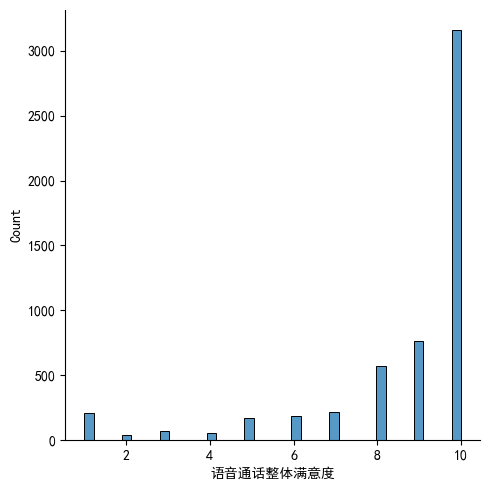

In [22]:
print("语音通话整体满意度--Mean:",round(train_data_1["语音通话整体满意度"].mean(),0))
print("语音通话整体满意度--Median:",train_data_1["语音通话整体满意度"].median())
print("语音通话整体满意度--Mode:",train_data_1["语音通话整体满意度"].mode()[0])
sns.displot(train_data_1["语音通话整体满意度"])
# train_data_1["语音通话整体满意度"].hist(bins=20, grid=False)
# plt.title("语音通话整体满意度");

##### 相关性分析 

In [124]:
corr = train_data_1.corr().abs()

In [125]:
cor = pd.DataFrame(train_data_1.corr().abs()["语音通话整体满意度"].sort_values(ascending = False))
cor.columns = ["语音通话整体满意度"]
cor[0:10]

,语音通话整体满意度
语音通话整体满意度,1.000000
是否遇到过网络问题,0.408153
居民小区,0.382392
手机没有信号,0.366982
有信号无法拨通,0.358712
通话过程中突然中断,0.339000
办公室,0.338380
通话过程中一方听不见,0.325703
通话中有杂音、听不清、断断续续,0.321666
商业街,0.229199


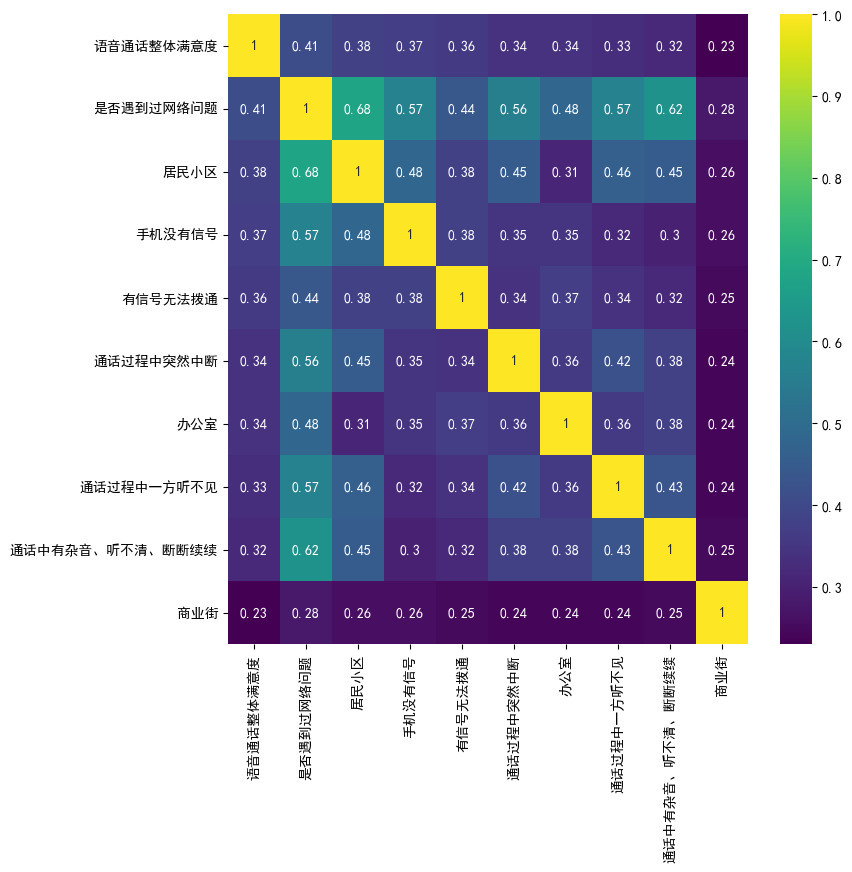

In [126]:
k = 10
col = corr.nlargest(k, '语音通话整体满意度')['语音通话整体满意度'].index   #Top10 index
corr = corr.loc[col, col]   
corr = corr.round(2)       

plt.subplots(figsize=(10, 10))
plt.subplots_adjust(left=0.25, bottom=0.25)
sns.heatmap(corr, annot=True, fmt="g", cmap='viridis')
plt.savefig('./output/语音通话整体满意度相关性.png', dpi=300)
plt.show()

In [26]:
x = train_data_1.loc[:, col].drop(['语音通话整体满意度'],axis=1)
x

,是否遇到过网络问题,居民小区,手机没有信号,有信号无法拨通,通话过程中突然中断,办公室,通话过程中一方听不见,通话中有杂音、听不清、断断续续,商业街
0,0,0,0,1,0,1,0,1,0
1,0,1,0,0,0,1,1,1,1
2,0,0,1,0,0,0,1,0,0
3,0,1,1,1,0,1,0,0,0
4,0,0,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
5428,0,0,0,0,1,1,1,0,0
5429,0,1,0,0,0,1,1,1,0
5430,0,0,1,1,0,0,0,0,1
5431,0,0,0,0,1,0,0,1,0


In [27]:
y = train_data_1["语音通话整体满意度"]
y

0       10
1        2
2       10
3        6
4        5
        ..
5428    10
5429    10
5430     6
5431     9
5432    10
Name: 语音通话整体满意度, Length: 5433, dtype: int64

In [28]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [29]:
# scaler = StandardScaler()
# scaler.fit(x_train)

In [30]:
features = x_train.columns
features

Index(['是否遇到过网络问题', '居民小区', '手机没有信号', '有信号无法拨通', '通话过程中突然中断', '办公室',
       '通话过程中一方听不见', '通话中有杂音、听不清、断断续续', '商业街'],
      dtype='object')

In [31]:
# x_train[features] = scaler.transform(x_train)
# x_train[features]

In [32]:
# x_val[features] = scaler.transform(x_val)
# x_val[features]

##### 回归 

In [33]:
val_set = pd.DataFrame()

def predict(model, val_set):
    start = time()
    pred = model.predict(x_val[features])
    end = time()        
    temp = pd.DataFrame(
            {
                "R2 Score":("%0.3f" % (r2_score(y_val,pred))),
                "Adjusted R2":("%0.3f" % (1-(1-r2_score(y_val,pred))*(x_train[features].shape[0]-1)/(x_train[features].shape[0]-x_train[features].shape[1]-1))),
                "Mean Absolute Error":("%0.3f" % (mean_absolute_error(y_val,pred))),
                "Mean Squared Error":("%0.3f" % (mean_squared_error(y_val,pred))),
                "Root Mean Square Error":("%0.3f" % (np.sqrt(mean_squared_error(y_val,pred)))),
                "Latency":("%0.1fms" % ((end-start)*1000))
            }, index=[(str(model).split("Regressor")[0].split("(")[0])]
    )
    val_set = pd.concat([val_set,temp])
    return val_set

In [34]:
rg = Ridge()
parameters = {
    "alpha":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "normalize":[True,False]
}

rg_cv = GridSearchCV(rg, parameters, cv=5)
rg_cv.fit(x_train[features],y_train.values.ravel())
rg_cv.best_estimator_

Ridge(normalize=True)

In [35]:
val_set = predict(rg_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms


In [36]:
dt = DecisionTreeRegressor()
parameters = {
    "criterion":["squared_error","friedman_mse","absolute_error"],
    "max_depth":[2,4,8,16,32],
    "min_samples_leaf":[2,4,8,16,32],
    "min_samples_split":[2,4,8,16,32]
}

dt_cv = GridSearchCV(dt, parameters, cv=5)
dt_cv.fit(x_train[features],y_train.values.ravel())
dt_cv.best_estimator_

DecisionTreeRegressor(max_depth=8, min_samples_leaf=32)

In [37]:
val_set = predict(dt_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,3.0ms


In [38]:
rf = RandomForestRegressor()
parameters = {
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(x_train[features],y_train.values.ravel())
rf_cv.best_estimator_

RandomForestRegressor(max_depth=4, n_estimators=50)

In [39]:
val_set = predict(rf_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,3.0ms
RandomForest,0.245,0.243,1.273,3.962,1.991,2.0ms


In [40]:
ada = AdaBoostRegressor()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "loss":["linear","square","exponential"],
    "n_estimators":[5,50,250,500]
}

ada_cv = GridSearchCV(ada, parameters, cv=5)
ada_cv.fit(x_train[features],y_train.values.ravel())
ada_cv.best_estimator_

AdaBoostRegressor(learning_rate=0.01, loss='square')

In [41]:
val_set = predict(ada_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,3.0ms
RandomForest,0.245,0.243,1.273,3.962,1.991,2.0ms
AdaBoost,0.227,0.225,1.343,4.059,2.015,22.0ms


In [42]:
gb = GradientBoostingRegressor()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

gb_cv = GridSearchCV(gb, parameters, cv=5)
gb_cv.fit(x_train[features],y_train.values.ravel())
gb_cv.best_estimator_

GradientBoostingRegressor(max_depth=2, n_estimators=50)

In [43]:
val_set = predict(gb_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,3.0ms
RandomForest,0.245,0.243,1.273,3.962,1.991,2.0ms
AdaBoost,0.227,0.225,1.343,4.059,2.015,22.0ms
GradientBoosting,0.255,0.254,1.266,3.909,1.977,3.0ms


In [44]:
xgb = XGBRegressor()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[2,4,8,16,32],
    "learning_rate":[0.01,0.1,1.0,10,100]
}

xgb_cv = GridSearchCV(xgb, parameters, cv=5)
xgb_cv.fit(x_train[features],y_train.values.ravel())
xgb_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [45]:
val_set = predict(xgb_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,3.0ms
RandomForest,0.245,0.243,1.273,3.962,1.991,2.0ms
AdaBoost,0.227,0.225,1.343,4.059,2.015,22.0ms
GradientBoosting,0.255,0.254,1.266,3.909,1.977,3.0ms
XGB,0.256,0.254,1.284,3.906,1.976,4.0ms


In [46]:
svr = SVR()
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "kernel":["linear","poly","rbf","sigmoid"]
}

svr_cv = GridSearchCV(svr, parameters, cv=5)
svr_cv.fit(x_train[features],y_train.values.ravel())
svr_cv.best_estimator_

SVR(C=100, kernel='linear')

In [47]:
val_set = predict(svr_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,3.0ms
RandomForest,0.245,0.243,1.273,3.962,1.991,2.0ms
AdaBoost,0.227,0.225,1.343,4.059,2.015,22.0ms
GradientBoosting,0.255,0.254,1.266,3.909,1.977,3.0ms
XGB,0.256,0.254,1.284,3.906,1.976,4.0ms
SVR,0.181,0.179,1.135,4.298,2.073,11.0ms


In [48]:
mlp = MLPRegressor()
parameters = {
    "activation":["identity","logistic","tanh","relu"],
    "hidden_layer_sizes":[(10,),(50,),(100,)],
    "learning_rate":["constant","invscaling","adaptive"],
    "solver":["lbfgs","sgd","adam"]
}

mlp_cv = GridSearchCV(mlp, parameters, cv=5)
mlp_cv.fit(x_train[features],y_train.values.ravel())
mlp_cv.best_estimator_

MLPRegressor(hidden_layer_sizes=(50,), learning_rate='adaptive', solver='sgd')

In [49]:
val_set = predict(mlp_cv.best_estimator_, val_set)
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,3.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,3.0ms
RandomForest,0.245,0.243,1.273,3.962,1.991,2.0ms
AdaBoost,0.227,0.225,1.343,4.059,2.015,22.0ms
GradientBoosting,0.255,0.254,1.266,3.909,1.977,3.0ms
XGB,0.256,0.254,1.284,3.906,1.976,4.0ms
SVR,0.181,0.179,1.135,4.298,2.073,11.0ms
MLP,0.257,0.255,1.270,3.901,1.975,5.0ms


In [50]:
estimators = [("rg",rg_cv.best_estimator_),
              ("dt",dt_cv.best_estimator_),
              ("rf",rf_cv.best_estimator_),
              ("ada",ada_cv.best_estimator_),
              ("gb",gb_cv.best_estimator_),
              ("xgb",xgb_cv.best_estimator_),
              ("svr",svr_cv.best_estimator_),
              ("mlp",mlp_cv.best_estimator_)]

sr = StackingRegressor(estimators=estimators)
parameters = {
    "passthrough":[True,False]
}

sr_cv = GridSearchCV(sr, parameters, cv=5)
sr_cv.fit(x_train[features],y_train.values.ravel())
sr_cv.best_estimator_

StackingRegressor(estimators=[('rg', Ridge(normalize=True)),
                              ('dt',
                               DecisionTreeRegressor(max_depth=8,
                                                     min_samples_leaf=32)),
                              ('rf',
                               RandomForestRegressor(max_depth=4,
                                                     n_estimators=50)),
                              ('ada',
                               AdaBoostRegressor(learning_rate=0.01,
                                                 loss='square')),
                              ('gb',
                               GradientBoostingRegressor(max_depth=2,
                                                         n_estimators=50)),
                              ('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtre...
                                            missing=nan,
                                            monotone_con

In [51]:
models = [rg_cv.best_estimator_,
          dt_cv.best_estimator_,
          rf_cv.best_estimator_,
          ada_cv.best_estimator_,
          gb_cv.best_estimator_,
          xgb_cv.best_estimator_,
          svr_cv.best_estimator_,
          mlp_cv.best_estimator_,
          sr_cv.best_estimator_]

In [52]:
val_set = pd.DataFrame()
    
for i in models:
    
        start = time()
        pred = i.predict(x_val)
        end = time()        
        temp = pd.DataFrame(
                {
                    "R2 Score":("%0.3f" % (r2_score(y_val,pred))),
                    "Adjusted R2":("%0.3f" % (1-(1-r2_score(y_val,pred))*(x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1))),
                    "Mean Absolute Error":("%0.3f" % (mean_absolute_error(y_val,pred))),
                    "Mean Squared Error":("%0.3f" % (mean_squared_error(y_val,pred))),
                    "Root Mean Square Error":("%0.3f" % (np.sqrt(mean_squared_error(y_val,pred)))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[(str(i).split("Regressor")[0].split("(")[0])]
        )
        val_set = pd.concat([val_set,temp])
val_set

,R2 Score,Adjusted R2,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Latency
Ridge,0.255,0.253,1.263,3.912,1.978,2.0ms
DecisionTree,0.225,0.224,1.292,4.066,2.016,1.0ms
RandomForest,0.245,0.243,1.273,3.962,1.991,2.0ms
AdaBoost,0.227,0.225,1.343,4.059,2.015,13.0ms
GradientBoosting,0.255,0.254,1.266,3.909,1.977,2.0ms
XGB,0.256,0.254,1.284,3.906,1.976,2.0ms
SVR,0.181,0.179,1.135,4.298,2.073,5.0ms
MLP,0.257,0.255,1.270,3.901,1.975,1.0ms
Stacking,0.256,0.254,1.265,3.905,1.976,35.9ms


##### 分类 

In [53]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [54]:
rg = RidgeClassifier()
parameters = {
    "alpha":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    "normalize":[True,False]
}

rg_cv = GridSearchCV(rg, parameters, cv=5)
rg_cv.fit(x_train,y_train)
rg_cv.best_estimator_

RidgeClassifier(alpha=0.2, normalize=True)

In [55]:
dt = DecisionTreeClassifier()
parameters = {
    "criterion":['gini', 'entropy','log_loss'],
    "max_depth":[2,4,8,16,32],
    "min_samples_leaf":[2,4,8,16,32],
    "min_samples_split":[2,4,8,16,32]
}

dt_cv = GridSearchCV(dt, parameters, cv=5)
dt_cv.fit(x_train,y_train)
dt_cv.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)

In [56]:
rf = RandomForestClassifier()
parameters = {
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(x_train,y_train)
rf_cv.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=250)

In [57]:
ada = AdaBoostClassifier()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "n_estimators":[5,50,250,500]
}

ada_cv = GridSearchCV(ada, parameters, cv=5)
ada_cv.fit(x_train,y_train)
ada_cv.best_estimator_

AdaBoostClassifier(learning_rate=0.01, n_estimators=500)

In [58]:
gb = GradientBoostingClassifier()
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "max_depth":[2,4,8,16,32],
    "n_estimators":[5,50,250,500]
}

gb_cv = GridSearchCV(gb, parameters, cv=5)
gb_cv.fit(x_train,y_train)
gb_cv.best_estimator_

GradientBoostingClassifier(max_depth=2, n_estimators=50)

In [59]:
xgb = XGBClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[2,4,8,16,32],
    "learning_rate":[0.01,0.1,1.0,10,100]
}

xgb_cv = GridSearchCV(xgb, parameters, cv=5)
xgb_cv.fit(x_train,y_train)
xgb_cv.best_estimator_

[01:45:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:45:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:45:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:45:36] WARNI

[01:45:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:45:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:45:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:45:55] WARNI

[01:46:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:46:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:46:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:46:44] WARNI

[01:48:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:48:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:48:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:48:50] WARNI

[01:50:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:40] WARNI

[01:50:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:59] WARNI

[01:51:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:51:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:51:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:51:54] WARNI

[01:53:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:42] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:54:03] WARNI

[01:55:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:38] WARNI

[01:55:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:55:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:56:02] WARNI

[01:57:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:57:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:57:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:57:31] WARNI

[01:58:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:59:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:59:00] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:59:00] WARNI

[02:00:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:19] WARNI

[02:00:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:36] WARNI

[02:00:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:54] WARNI

[02:01:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:07] WARNI

[02:01:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:23] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:24] WARNI

[02:01:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:42] WARNI

[02:01:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:01:57] WARNI

[02:02:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:02:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:02:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:02:10] WARNI

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [60]:
svr = SVC()
parameters = {
    "C":[0.001,0.01,0.1,1.0,10,100,1000],
    "kernel":["linear","poly","rbf","sigmoid"]
}

svr_cv = GridSearchCV(svr, parameters, cv=5)
svr_cv.fit(x_train,y_train)
svr_cv.best_estimator_

SVC(C=0.1, kernel='poly')

In [61]:
mlp = MLPClassifier()
parameters = {
    "activation":["identity","logistic","tanh","relu"],
    "hidden_layer_sizes":[(10,),(50,),(100,)],
    "learning_rate":["constant","invscaling","adaptive"],
    "solver":["lbfgs","sgd","adam"]
}

mlp_cv = GridSearchCV(mlp, parameters, cv=5)
mlp_cv.fit(x_train, y_train)
mlp_cv.best_estimator_

MLPClassifier(solver='sgd')

In [62]:
estimators = [("rg",rg_cv.best_estimator_),
              ("dt",dt_cv.best_estimator_),
              ("rf",rf_cv.best_estimator_),
              ("ada",ada_cv.best_estimator_),
              ("gb",gb_cv.best_estimator_),
              ("xgb",xgb_cv.best_estimator_),
              ("svr",svr_cv.best_estimator_),
              ("mlp",mlp_cv.best_estimator_)]

sr = StackingClassifier(estimators=estimators)
parameters = {
    "passthrough":[True,False]
}

sr_cv = GridSearchCV(sr, parameters, cv=5)
sr_cv.fit(x_train,y_train)
sr_cv.best_estimator_

[02:40:06] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:29] WARNI

[02:43:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:32] WARNI

[02:46:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:36] WARNI

StackingClassifier(estimators=[('rg',
                                RidgeClassifier(alpha=0.2, normalize=True)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=2,
                                                       min_samples_leaf=2)),
                               ('rf',
                                RandomForestClassifier(max_depth=4,
                                                       n_estimators=250)),
                               ('ada',
                                AdaBoostClassifier(learning_rate=0.01,
                                                   n_estimators=500)),
                               ('gb',
                                GradientBoostingClassifier(max_depth=2,
                                                           n_estimators=50)),
                               ('xgb',
                                XGBClassifier(...
                                              min_child_weight=

In [63]:
models = [rg_cv.best_estimator_,
          dt_cv.best_estimator_,
          rf_cv.best_estimator_,
          ada_cv.best_estimator_,
          gb_cv.best_estimator_,
          xgb_cv.best_estimator_,
          svr_cv.best_estimator_,
          mlp_cv.best_estimator_,
          sr_cv.best_estimator_]

In [64]:
val_set = pd.DataFrame()
    
for i in models:
        start = time()
        pred = i.predict(x_val)
        end = time()        
        temp = pd.DataFrame(
                {
                    "Mean Absolute Error":("%0.3f" % (mean_absolute_error(y_val,pred))),
                    "Mean Squared Error":("%0.3f" % (mean_squared_error(y_val,pred))),
                    "Root Mean Square Error":("%0.3f" % (np.sqrt(mean_squared_error(y_val,pred)))),
                    "Acc":("%0.3f" % (np.sqrt(accuracy_score(y_val,pred)))),
                    "Latency":("%0.1fms" % ((end-start)*1000))
                }, index=[(str(i).split("Regressor")[0].split("(")[0])]
        )
        val_set = pd.concat([val_set,temp])
val_set

,Mean Absolute Error,Mean Squared Error,Root Mean Square Error,Acc,Latency
RidgeClassifier,1.259,6.322,2.514,0.764,2.0ms
DecisionTreeClassifier,1.320,6.991,2.644,0.763,2.0ms
RandomForestClassifier,1.273,6.530,2.555,0.765,4.0ms
AdaBoostClassifier,1.294,6.645,2.578,0.762,279.3ms
GradientBoostingClassifier,1.294,6.706,2.590,0.766,9.0ms
XGBClassifier,1.242,6.215,2.493,0.765,12.0ms
SVC,1.261,6.404,2.531,0.764,23.9ms
MLPClassifier,1.233,6.175,2.485,0.768,2.0ms
StackingClassifier,1.269,6.431,2.536,0.764,316.2ms


### 测试集预处理 

In [101]:
test = pd.read_excel("./data/附件3语音业务用户满意度预测数据.xlsx")

In [102]:
test.shape

(2599, 44)

In [103]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2599 entries, 0 to 2598
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   用户id               2599 non-null   int64  
 1   是否遇到过网络问题          2599 non-null   int64  
 2   居民小区               2599 non-null   int64  
 3   办公室                2599 non-null   int64  
 4   高校                 2599 non-null   int64  
 5   商业街                2599 non-null   int64  
 6   地铁                 2599 non-null   int64  
 7   农村                 2599 non-null   int64  
 8   高铁                 2599 non-null   int64  
 9   其他，请注明             2599 non-null   int64  
 10  用户描述               109 non-null    object 
 11  手机没有信号             2599 non-null   int64  
 12  有信号无法拨通            2599 non-null   int64  
 13  通话过程中突然中断          2599 non-null   int64  
 14  通话中有杂音、听不清、断断续续    2599 non-null   int64  
 15  串线                 2599 non-null   int64  
 16  通话过程中一方听不见         2599 

In [104]:
test_data = pd.DataFrame.copy(test, deep=True)
test_data

,用户id,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,当月ARPU,当月MOU,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,客户星级标识,是否不限量套餐到达用户
0,1,2,-1,-1,-1,-1,-1,-1,-1,-1,...,45.37,161,23.6,139,0.000000,14360274,0,否,一星,否
1,2,1,1,2,-1,-1,-1,-1,-1,-1,...,60.00,270,60.0,102,0.000000,9585266,0,否,三星,是
2,3,2,-1,-1,-1,-1,-1,-1,-1,-1,...,89.00,662,89.0,80,0.000000,6545659,0,否,三星,是
3,4,1,1,-1,-1,-1,-1,-1,-1,-1,...,70.00,645,69.1,333,0.000000,8266166,0,否,三星,否
4,5,1,1,-1,-1,-1,-1,-1,-1,-1,...,56.00,496,56.0,258,0.000000,13254086,0,是,三星,是
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2595,1,-1,-1,-1,-1,-1,-1,7,-1,...,47.00,110,197.0,42,0.000000,34089161,0,否,三星,否
2595,2596,2,-1,-1,-1,-1,-1,-1,-1,-1,...,57.00,238,77.0,157,0.000000,4355664,0,否,三星,否
2596,2597,2,-1,-1,-1,-1,-1,-1,-1,-1,...,8.10,202,8.0,194,0.000000,27678375,0,是,三星,否
2597,2598,1,-1,-1,-1,-1,-1,6,7,-1,...,58.20,148,58.3,66,0.061913,5410723,334996,否,三星,否


In [105]:
test_data.isnull().sum().sort_values(ascending=False)/len(test_data)*100

用户描述.1               98.422470
用户描述                 95.806079
用户id                  0.000000
终端品牌类型                0.000000
是否关怀用户                0.000000
套外流量（MB）              0.000000
是否4G网络客户（本地剔除物联网）     0.000000
套外流量费（元）              0.000000
外省语音占比                0.000000
语音通话-时长（分钟）           0.000000
省际漫游-时长（分钟）           0.000000
终端品牌                  0.000000
当月ARPU                0.000000
性别                    0.000000
当月MOU                 0.000000
前3月ARPU               0.000000
前3月MOU                0.000000
外省流量占比                0.000000
GPRS总流量（KB）           0.000000
GPRS-国内漫游-流量（KB）      0.000000
是否5G网络客户              0.000000
客户星级标识                0.000000
4\5G用户                0.000000
是否投诉                  0.000000
是否遇到过网络问题             0.000000
未接通掉话次数               0.000000
居民小区                  0.000000
办公室                   0.000000
高校                    0.000000
商业街                   0.000000
地铁                    0.000000
农村                    0.000000
高铁      

In [106]:
test_data=test_data.drop(['用户描述.1', '用户描述'],axis=1)
test_data

,用户id,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,当月ARPU,当月MOU,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,客户星级标识,是否不限量套餐到达用户
0,1,2,-1,-1,-1,-1,-1,-1,-1,-1,...,45.37,161,23.6,139,0.000000,14360274,0,否,一星,否
1,2,1,1,2,-1,-1,-1,-1,-1,-1,...,60.00,270,60.0,102,0.000000,9585266,0,否,三星,是
2,3,2,-1,-1,-1,-1,-1,-1,-1,-1,...,89.00,662,89.0,80,0.000000,6545659,0,否,三星,是
3,4,1,1,-1,-1,-1,-1,-1,-1,-1,...,70.00,645,69.1,333,0.000000,8266166,0,否,三星,否
4,5,1,1,-1,-1,-1,-1,-1,-1,-1,...,56.00,496,56.0,258,0.000000,13254086,0,是,三星,是
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2595,1,-1,-1,-1,-1,-1,-1,7,-1,...,47.00,110,197.0,42,0.000000,34089161,0,否,三星,否
2595,2596,2,-1,-1,-1,-1,-1,-1,-1,-1,...,57.00,238,77.0,157,0.000000,4355664,0,否,三星,否
2596,2597,2,-1,-1,-1,-1,-1,-1,-1,-1,...,8.10,202,8.0,194,0.000000,27678375,0,是,三星,否
2597,2598,1,-1,-1,-1,-1,-1,6,7,-1,...,58.20,148,58.3,66,0.061913,5410723,334996,否,三星,否


In [107]:
for col in test_data:
    if col not in train_data:
        test_data=test_data.drop(col,axis=1)
test_data

,用户id,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,省际漫游-时长（分钟）,当月ARPU,当月MOU,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,客户星级标识
0,1,2,-1,-1,-1,-1,-1,-1,-1,-1,...,0,45.37,161,23.6,139,0.000000,14360274,0,否,一星
1,2,1,1,2,-1,-1,-1,-1,-1,-1,...,0,60.00,270,60.0,102,0.000000,9585266,0,否,三星
2,3,2,-1,-1,-1,-1,-1,-1,-1,-1,...,0,89.00,662,89.0,80,0.000000,6545659,0,否,三星
3,4,1,1,-1,-1,-1,-1,-1,-1,-1,...,0,70.00,645,69.1,333,0.000000,8266166,0,否,三星
4,5,1,1,-1,-1,-1,-1,-1,-1,-1,...,0,56.00,496,56.0,258,0.000000,13254086,0,是,三星
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2595,1,-1,-1,-1,-1,-1,-1,7,-1,...,0,47.00,110,197.0,42,0.000000,34089161,0,否,三星
2595,2596,2,-1,-1,-1,-1,-1,-1,-1,-1,...,0,57.00,238,77.0,157,0.000000,4355664,0,否,三星
2596,2597,2,-1,-1,-1,-1,-1,-1,-1,-1,...,0,8.10,202,8.0,194,0.000000,27678375,0,是,三星
2597,2598,1,-1,-1,-1,-1,-1,6,7,-1,...,0,58.20,148,58.3,66,0.061913,5410723,334996,否,三星


In [108]:
test_data.isnull().sum().sort_values(ascending=False)/len(test_data)*100

用户id                 0.0
未接通掉话次数              0.0
是否关怀用户               0.0
套外流量（MB）             0.0
是否4G网络客户（本地剔除物联网）    0.0
套外流量费（元）             0.0
外省语音占比               0.0
语音通话-时长（分钟）          0.0
省际漫游-时长（分钟）          0.0
当月ARPU               0.0
当月MOU                0.0
前3月ARPU              0.0
前3月MOU               0.0
外省流量占比               0.0
GPRS总流量（KB）          0.0
GPRS-国内漫游-流量（KB）     0.0
是否5G网络客户             0.0
4\5G用户               0.0
mos质差次数              0.0
是否遇到过网络问题            0.0
脱网次数                 0.0
居民小区                 0.0
办公室                  0.0
高校                   0.0
商业街                  0.0
地铁                   0.0
农村                   0.0
高铁                   0.0
其他，请注明               0.0
手机没有信号               0.0
有信号无法拨通              0.0
通话过程中突然中断            0.0
通话中有杂音、听不清、断断续续      0.0
串线                   0.0
通话过程中一方听不见           0.0
其他，请注明.1             0.0
客户星级标识               0.0
dtype: float64

In [110]:
test_data=test_data.replace({
        '是否投诉': {'是': 1, '否': 0},
        '是否关怀用户': {'是': 1, '否': 0},
        '4\\5G用户': {'2G': 0, '4G': 1, '5G': 2},
        '是否去过营业厅': {'是': 1, '否': 0},
        '是否4G网络客户（本地剔除物联网）': {'是': 1, '否': 0},
        '是否5G网络客户': {'是': 1, '否': 0},
        '是否实名登记用户':{'是': 1, '否': 0},
        '客户星级标识': {'未评级': 0, '准星': 1, '一星': 2, '二星': 3, '三星': 4, '白金卡': 5, '钻石卡': 6, '银卡': 7,'金卡': 8},
        '语音方式': {'CSFB': 0, 'EPSFB': 1, 'GSM': 2, 'VOLTE':3, 'VONR':4, 'VoLTE':5},

        '是否遇到过网络问题': {1: 0, 2: 1},

        '居民小区': {-1: 0},
        '办公室': {-1: 0, 2: 1},
        '高校': {-1: 0, 3: 1},
        '商业街': {-1: 0, 4: 1},
        '地铁': {-1: 0, 5: 1},
        '农村': {-1: 0, 6: 1},
        '高铁': {-1: 0, 7: 1},
        '其他，请注明': {-1: 0, 98: 1},

        '手机没有信号': {-1: 0},
        '有信号无法拨通': {-1: 0, 2: 1},
        '通话过程中突然中断': {-1: 0, 3: 1},
        '通话中有杂音、听不清、断断续续': {-1: 0, 4: 1},
        '串线': {-1: 0, 5: 1},
        '通话过程中一方听不见': {-1: 0, 6: 1},
        '其他，请注明.1': {-1: 0, 98: 1},

    })
test_data

,用户id,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,省际漫游-时长（分钟）,当月ARPU,当月MOU,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,客户星级标识
0,1,1,0,0,0,0,0,0,0,0,...,0,45.37,161,23.6,139,0.000000,14360274,0,0,2
1,2,0,1,1,0,0,0,0,0,0,...,0,60.00,270,60.0,102,0.000000,9585266,0,0,4
2,3,1,0,0,0,0,0,0,0,0,...,0,89.00,662,89.0,80,0.000000,6545659,0,0,4
3,4,0,1,0,0,0,0,0,0,0,...,0,70.00,645,69.1,333,0.000000,8266166,0,0,4
4,5,0,1,0,0,0,0,0,0,0,...,0,56.00,496,56.0,258,0.000000,13254086,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2595,0,0,0,0,0,0,0,1,0,...,0,47.00,110,197.0,42,0.000000,34089161,0,0,4
2595,2596,1,0,0,0,0,0,0,0,0,...,0,57.00,238,77.0,157,0.000000,4355664,0,0,4
2596,2597,1,0,0,0,0,0,0,0,0,...,0,8.10,202,8.0,194,0.000000,27678375,0,1,4
2597,2598,0,0,0,0,0,0,1,1,0,...,0,58.20,148,58.3,66,0.061913,5410723,334996,0,4


In [111]:
test_data.to_excel('./output/语音测试集.xlsx', index=False)

### 预测（MLPClassifier） 

In [119]:
test = pd.read_excel("./output/语音测试集.xlsx")

In [120]:
test_data = pd.DataFrame.copy(test, deep=True)
test_data

,用户id,是否遇到过网络问题,居民小区,办公室,高校,商业街,地铁,农村,高铁,其他，请注明,...,省际漫游-时长（分钟）,当月ARPU,当月MOU,前3月ARPU,前3月MOU,外省流量占比,GPRS总流量（KB）,GPRS-国内漫游-流量（KB）,是否5G网络客户,客户星级标识
0,1,1,0,0,0,0,0,0,0,0,...,0,45.37,161,23.6,139,0.000000,14360274,0,0,2
1,2,0,1,1,0,0,0,0,0,0,...,0,60.00,270,60.0,102,0.000000,9585266,0,0,4
2,3,1,0,0,0,0,0,0,0,0,...,0,89.00,662,89.0,80,0.000000,6545659,0,0,4
3,4,0,1,0,0,0,0,0,0,0,...,0,70.00,645,69.1,333,0.000000,8266166,0,0,4
4,5,0,1,0,0,0,0,0,0,0,...,0,56.00,496,56.0,258,0.000000,13254086,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,2595,0,0,0,0,0,0,0,1,0,...,0,47.00,110,197.0,42,0.000000,34089161,0,0,4
2595,2596,1,0,0,0,0,0,0,0,0,...,0,57.00,238,77.0,157,0.000000,4355664,0,0,4
2596,2597,1,0,0,0,0,0,0,0,0,...,0,8.10,202,8.0,194,0.000000,27678375,0,1,4
2597,2598,0,0,0,0,0,0,1,1,0,...,0,58.20,148,58.3,66,0.061913,5410723,334996,0,4


In [127]:
col

Index(['语音通话整体满意度', '是否遇到过网络问题', '居民小区', '手机没有信号', '有信号无法拨通', '通话过程中突然中断',
       '办公室', '通话过程中一方听不见', '通话中有杂音、听不清、断断续续', '商业街'],
      dtype='object')

In [128]:
test_col = col.drop('语音通话整体满意度')

In [130]:
test_data = test_data.loc[:, test_col]
test_data

,是否遇到过网络问题,居民小区,手机没有信号,有信号无法拨通,通话过程中突然中断,办公室,通话过程中一方听不见,通话中有杂音、听不清、断断续续,商业街
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,1,0
2,1,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0
4,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2594,0,0,1,0,0,0,0,0,0
2595,1,0,0,0,0,0,0,0,0
2596,1,0,0,0,0,0,0,0,0
2597,0,0,0,0,0,0,1,0,0


In [133]:
y_pred_test = mlp_cv.best_estimator_.predict(test_data)
output = pd.DataFrame({'Id': test['用户id'], '语音通话整体满意度': np.round(y_pred_test, 0)})
output.to_excel('./output//result-语音通话整体满意度.xlsx', index=False)